In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

plt.style.use('ggplot')
sns.set_palette('deep')
SEED = 42


train = pd.read_csv('train.csv')
store = pd.read_csv('store.csv')
test_df = pd.read_csv('test.csv')
train.head()

C:\Users\mrdow\rossman_git\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\mrdow\AppData\Local\Temp\ipykernel_14692\2641756594.py:20: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('train.csv')


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [2]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [4]:
df = train.copy()
df.shape

(1017209, 9)

In [5]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
df = df.merge(store, how='left', on='Store')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [8]:
df.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [9]:
df.Date = pd.to_datetime(df.Date)
df = df.sort_values('Date')

In [10]:
df.StateHoliday.value_counts()

StateHoliday
0    855087
0    131072
a     20260
b      6690
c      4100
Name: count, dtype: int64

In [11]:
df[df.StateHoliday == '0']

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1015350,371,3,2013-01-02,7374,606,1,0,0,1,d,c,1970.0,7.0,2009.0,1,45.0,2014.0,"Feb,May,Aug,Nov"
1015346,367,3,2013-01-02,4052,488,1,0,0,1,d,c,2640.0,9.0,2012.0,0,NaN,NaN,NaN
1015347,368,3,2013-01-02,7296,586,1,0,0,1,d,c,1450.0,4.0,2005.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
1015348,369,3,2013-01-02,6063,541,1,0,0,1,d,c,5870.0,4.0,2014.0,0,NaN,NaN,NaN
1015349,370,3,2013-01-02,5462,524,1,0,0,1,d,a,8250.0,10.0,2000.0,1,31.0,2009.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,746,5,2015-07-31,9082,638,1,1,0,1,d,c,4330.0,2.0,2011.0,1,35.0,2011.0,"Mar,Jun,Sept,Dec"
746,747,5,2015-07-31,10708,826,1,1,0,1,c,c,45740.0,8.0,2008.0,0,NaN,NaN,NaN
747,748,5,2015-07-31,7481,578,1,1,0,1,d,a,2380.0,3.0,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
741,742,5,2015-07-31,10460,1016,1,1,0,1,d,c,4380.0,NaN,NaN,0,NaN,NaN,NaN


In [12]:
df[df.StateHoliday == 0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
589421,372,7,2014-01-19,0,0,0,0,0,0,d,c,4880.0,8.0,2010.0,1,18.0,2014.0,"Jan,Apr,Jul,Oct"
589417,368,7,2014-01-19,0,0,0,0,0,0,d,c,1450.0,4.0,2005.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
589418,369,7,2014-01-19,0,0,0,0,0,0,d,c,5870.0,4.0,2014.0,0,NaN,NaN,NaN
589419,370,7,2014-01-19,0,0,0,0,0,0,d,a,8250.0,10.0,2000.0,1,31.0,2009.0,"Jan,Apr,Jul,Oct"
589420,371,7,2014-01-19,0,0,0,0,0,0,d,c,1970.0,7.0,2009.0,1,45.0,2014.0,"Feb,May,Aug,Nov"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327697,751,4,2014-09-25,2842,453,1,0,0,0,a,a,650.0,10.0,2006.0,0,NaN,NaN,NaN
327698,752,4,2014-09-25,3853,407,1,0,0,0,a,a,970.0,3.0,2013.0,1,31.0,2013.0,"Feb,May,Aug,Nov"
327699,753,4,2014-09-25,6006,617,1,0,0,0,d,c,540.0,11.0,2012.0,1,35.0,2010.0,"Mar,Jun,Sept,Dec"
327700,754,4,2014-09-25,5345,769,1,0,0,0,c,c,380.0,5.0,2008.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"


In [13]:
df.StateHoliday = df.StateHoliday.apply(lambda x: '0' if x == 0 else x)
df.StateHoliday.value_counts()

StateHoliday
0    986159
a     20260
b      6690
c      4100
Name: count, dtype: int64

In [14]:
df.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000
mean,5.584297e+02,3.998341e+00,2014-04-11 01:30:42.846062080,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774
min,1.000000e+00,1.000000e+00,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000
25%,2.800000e+02,2.000000e+00,2013-08-17 00:00:00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000
50%,5.580000e+02,4.000000e+00,2014-04-02 00:00:00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000
75%,8.380000e+02,6.000000e+00,2014-12-12 00:00:00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000
max,1.115000e+03,7.000000e+00,2015-07-31 00:00:00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870


In [15]:
df.SchoolHoliday.value_counts()

SchoolHoliday
0    835488
1    181721
Name: count, dtype: int64

In [ ]:
len(df.Store.unique())

1115

In [ ]:
len(df.Date.unique())

942

Text(0.5, 0, 'Sales')

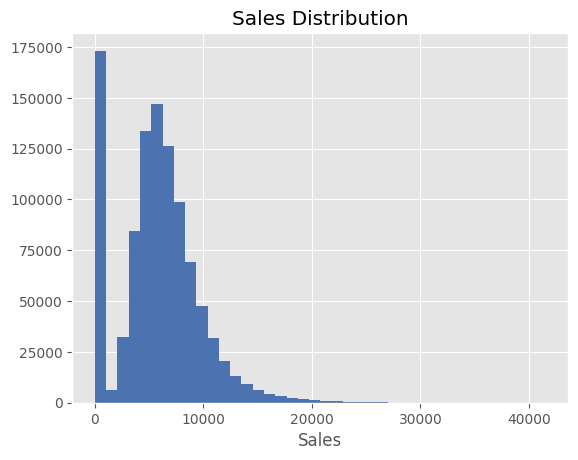

In [ ]:
plt.hist(df.Sales, bins=40)
plt.title('Sales Distribution')
plt.xlabel('Sales')

# In the plot, we can see that the sales data is highly skewed, with many values at zero.

Text(0.5, 0, 'logSales')

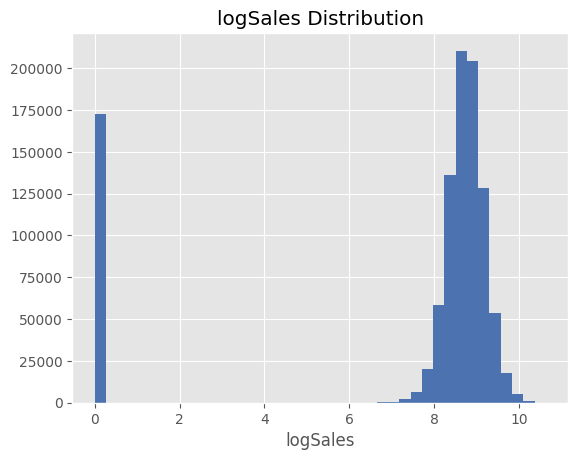

In [17]:
df['log_sales'] = np.log1p(df.Sales)

plt.hist(df.log_sales, bins=40)
plt.title('logSales Distribution')
plt.xlabel('logSales')

Text(0, 0.5, 'Sales')

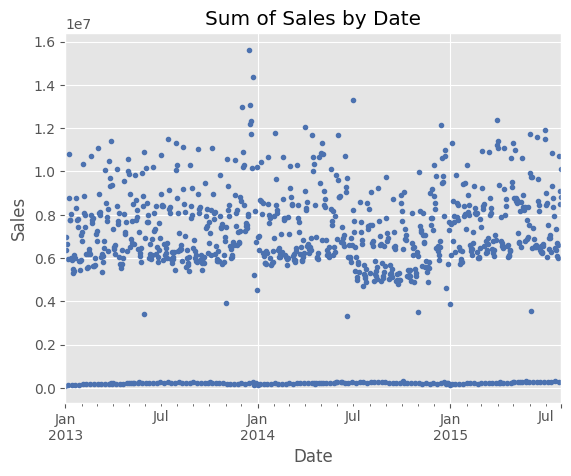

In [18]:
df.groupby('Date')['Sales'].sum().plot(style='.')
plt.title('Sum of Sales by Date')
plt.ylabel('Sales')

Text(0, 0.5, 'Sales')

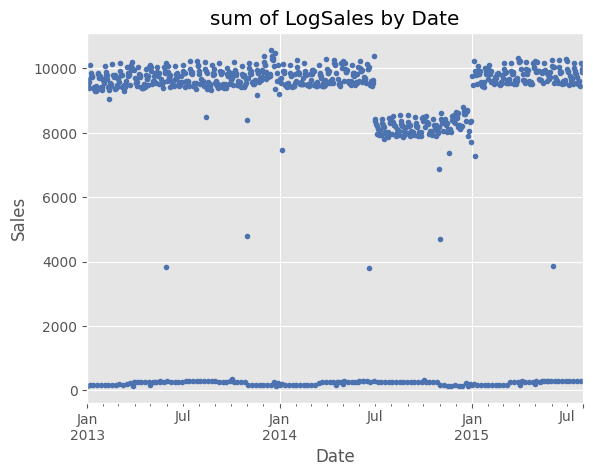

In [19]:
df.groupby('Date')['log_sales'].sum().plot(style='.')
plt.title('sum of LogSales by Date')
plt.ylabel('Sales')

# We can see in the plot that overall sales dropped significantly from July 2014 to January 2015.
# We also observe some unusual values in the middle of the distribution.

In [20]:
df = df[(df.log_sales <= 2) | (df.log_sales >= 6)]

# I decided to drop the uncommon values since there were only a few of them
# And doing so improved the score.

In [27]:
df[df.Open == 0]['Sales'].sum()

# Normally, closed stores shouldn't impact sales since they have no sales,
# but we need to verify this by checking the CV score.
# These rows might still contain valuable information.

np.int64(0)

Text(0.5, 1.0, 'Customer Distribution')

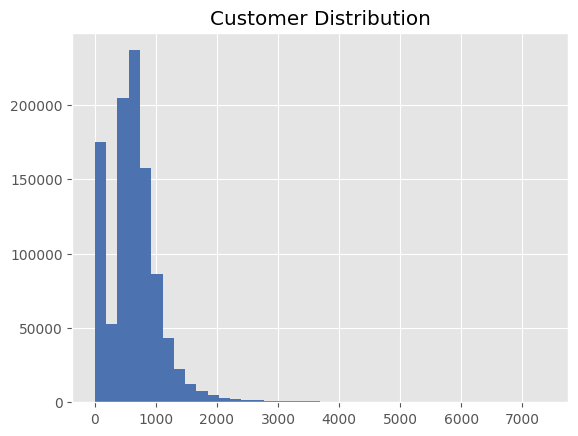

In [ ]:
plt.hist(df.Customers, bins=40)
plt.title('Customer Distribution')

In [ ]:
df['sales_per_customer'] = df['Sales'] / df['Customers']
# A 'sales per customer' feature was added to provide a clearer view of the sales.

In [ ]:
df.sort_values('Customers', ascending=False).head(20)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,log_sales,sales_z_score,sales_per_customer
993496,817,2,2013-01-22,27190,7388,1,1,0,0,a,...,140.0,3.0,2006.0,0,NaN,NaN,NaN,10.210641,0.888050,3.680292
319810,262,5,2014-10-03,35702,5494,1,1,a,0,b,...,1180.0,5.0,2013.0,0,NaN,NaN,NaN,10.482990,0.970280,6.498362
101726,262,5,2015-05-01,38484,5458,1,1,a,0,b,...,1180.0,5.0,2013.0,0,NaN,NaN,NaN,10.558024,0.992935,7.050934
432096,262,1,2014-06-09,34692,5387,1,0,a,0,b,...,1180.0,5.0,2013.0,0,NaN,NaN,NaN,10.454293,0.961616,6.439948
444361,262,4,2014-05-29,37403,5297,1,0,a,0,b,...,1180.0,5.0,2013.0,0,NaN,NaN,NaN,10.529533,0.984333,7.061167
87231,262,4,2015-05-14,38367,5192,1,0,a,1,b,...,1180.0,5.0,2013.0,0,NaN,NaN,NaN,10.554979,0.992016,7.389638
129601,262,1,2015-04-06,33655,5152,1,0,b,0,b,...,1180.0,5.0,2013.0,0,NaN,NaN,NaN,10.423947,0.952453,6.532415
745411,262,7,2013-09-01,32926,5145,1,0,0,0,b,...,1180.0,5.0,2013.0,0,NaN,NaN,NaN,10.402048,0.945841,6.399611
132946,262,5,2015-04-03,38722,5132,1,1,b,0,b,...,1180.0,5.0,2013.0,0,NaN,NaN,NaN,10.564189,0.994797,7.545207
776631,262,7,2013-08-04,32252,5112,1,0,0,0,b,...,1180.0,5.0,2013.0,0,NaN,NaN,NaN,10.381366,0.939597,6.309077


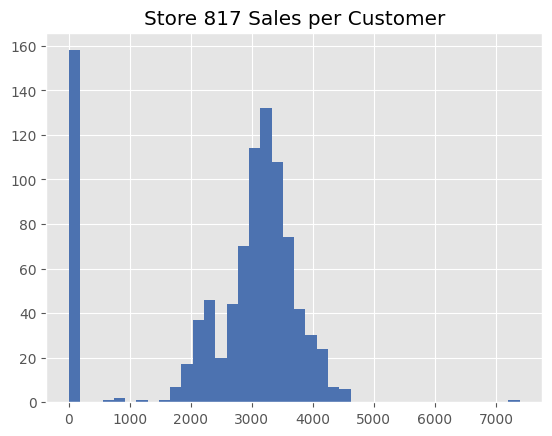

In [ ]:
store_817 = df[df['Store']==817].sort_values('Customers', ascending=False)
plt.hist(store_817.Customers, bins=40)
plt.title('Store 817 Sales per Customer')
plt.show()

In [ ]:
store_817.describe()

# Since Store 817 mean sales_per_customer = 6.93 and a standard deviation = 0.53,
# Row where customers = 7,388 and sales_per_customer = 3.68 is most likely isn't valid.

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,log_sales,sales_z_score,sales_per_customer
count,942.0,942.000000,942,942.000000,942.000000,942.000000,942.000000,942.000000,942.0,942.0,942.0,942.0,0.0,0.0,942.000000,942.000000,784.000000
mean,817.0,3.997877,2014-04-16 12:00:00,18108.139066,2605.488323,0.832272,0.382166,0.183652,140.0,3.0,2006.0,0.0,NaN,NaN,8.291403,0.308573,6.935960
min,817.0,1.000000,2013-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,140.0,3.0,2006.0,0.0,NaN,NaN,0.000000,-2.194855,3.680292
25%,817.0,2.000000,2013-08-24 06:00:00,14853.500000,2235.250000,1.000000,0.000000,0.000000,140.0,3.0,2006.0,0.0,NaN,NaN,9.606055,0.705506,6.597232
50%,817.0,4.000000,2014-04-16 12:00:00,20914.000000,3069.500000,1.000000,0.000000,0.000000,140.0,3.0,2006.0,0.0,NaN,NaN,9.948221,0.808817,6.889886
75%,817.0,6.000000,2014-12-07 18:00:00,23897.250000,3416.500000,1.000000,1.000000,0.000000,140.0,3.0,2006.0,0.0,NaN,NaN,10.081561,0.849076,7.275354
max,817.0,7.000000,2015-07-31 00:00:00,38025.000000,7388.000000,1.000000,1.000000,1.000000,140.0,3.0,2006.0,0.0,NaN,NaN,10.546025,0.989312,8.683681
std,0.0,1.998404,NaN,9183.542868,1290.924669,0.373823,0.486175,0.387406,0.0,0.0,0.0,0.0,NaN,NaN,3.730243,1.126274,0.530496


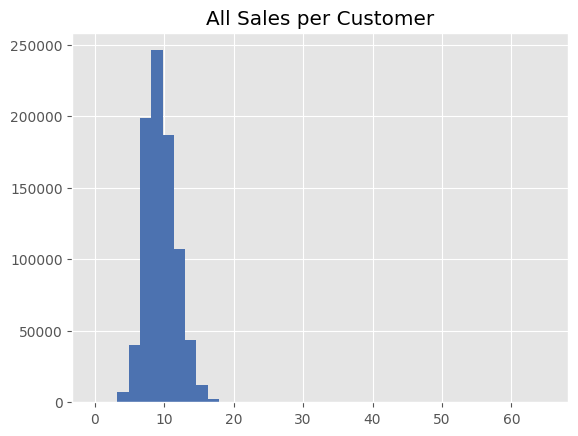

In [ ]:
plt.hist(df.sales_per_customer, bins=40)
plt.title('All Sales per Customer')
plt.show()

In [ ]:
df.describe()
# using describe method one more time to compare with Sales per Customer 

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,log_sales,sales_z_score,sales_per_customer
count,1.017203e+06,1.017203e+06,1017203,1.017203e+06,1.017203e+06,1.017203e+06,1.017203e+06,1.017203e+06,1.014561e+06,693858.000000,693858.000000,1.017203e+06,509177.000000,509177.000000,1.017203e+06,1.017203e+06,844334.000000
mean,5.584293e+02,3.998338e+00,2014-04-11 01:31:56.265287936,5.773852e+03,6.331495e+02,8.301057e-01,3.815148e-01,1.786477e-01,5.430042e+03,7.222863,2008.690216,5.005658e-01,23.269060,2011.752770,7.269404e+00,2.443165e-16,9.493633
min,1.000000e+00,1.000000e+00,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000,0.000000e+00,-2.194855e+00,0.000000
25%,2.800000e+02,2.000000e+00,2013-08-17 00:00:00,3.728000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000,8.223895e+00,2.881902e-01,7.895575
50%,5.580000e+02,4.000000e+00,2014-04-02 00:00:00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000,8.656085e+00,4.186816e-01,9.250000
75%,8.380000e+02,6.000000e+00,2014-12-12 00:00:00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000,8.969160e+00,5.132085e-01,10.899729
max,1.115000e+03,7.000000e+00,2015-07-31 00:00:00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000,1.063470e+01,1.016086e+00,64.957854
std,3.219083e+02,1.997387e+00,NaN,3.849914e+03,4.644108e+02,3.755401e-01,4.857587e-01,3.830573e-01,7.715302e+03,3.211836,5.992652,4.999999e-01,14.095967,1.662869,3.312021e+00,1.000000e+00,2.197494


In [ ]:
spc_out = df[df.sales_per_customer > 20] # sales per customer outliers
spc_out.shape

(90, 21)

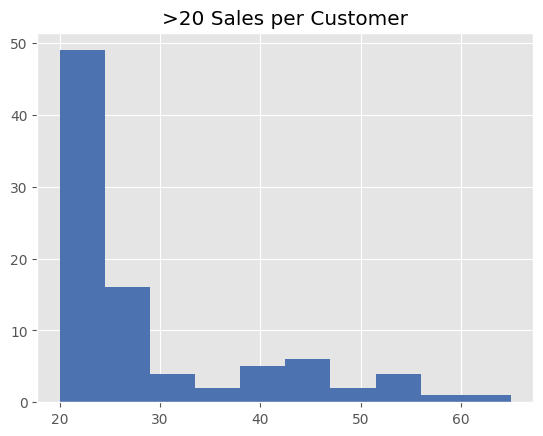

In [ ]:
plt.hist(spc_out.sales_per_customer)
plt.title('>20 Sales per Customer')
plt.show()

In [ ]:
spc_out.Store.value_counts()
# Store 126 seems to have more outliers than the others.

Store
126     30
897     12
985      6
956      6
548      6
612      4
937      3
13       3
803      3
1047     2
348      2
227      2
393      1
623      1
458      1
169      1
303      1
908      1
461      1
909      1
292      1
52       1
876      1
Name: count, dtype: int64

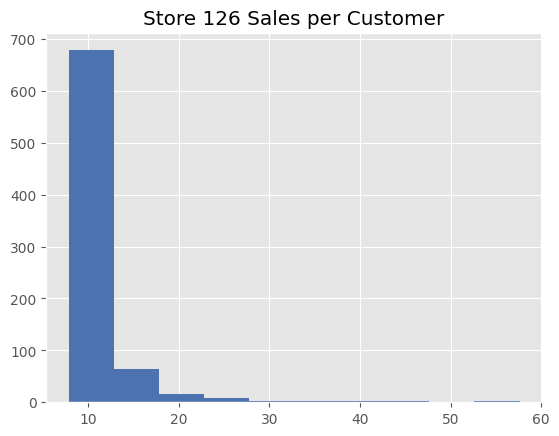

In [ ]:
store_126 = df[df.Store == 126]
plt.hist(store_126.sales_per_customer)
plt.title('Store 126 Sales per Customer')
plt.show()

In [ ]:
store_126.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,log_sales,sales_z_score,sales_per_customer
count,942.0,942.000000,942,942.000000,942.000000,942.000000,942.000000,942.000000,942.0,942.0,942.0,942.0,942.0,942.0,942.000000,942.000000,779.000000
mean,126.0,3.997877,2014-04-16 12:00:00,5381.677282,449.713376,0.826964,0.382166,0.180467,3370.0,10.0,2014.0,1.0,18.0,2011.0,7.200864,-0.020694,11.808638
min,126.0,1.000000,2013-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,3370.0,10.0,2014.0,1.0,18.0,2011.0,0.000000,-2.194855,7.858491
25%,126.0,2.000000,2013-08-24 06:00:00,4068.750000,427.000000,1.000000,0.000000,0.000000,3370.0,10.0,2014.0,1.0,18.0,2011.0,8.311337,0.314591,10.001982
50%,126.0,4.000000,2014-04-16 12:00:00,5316.500000,504.000000,1.000000,0.000000,0.000000,3370.0,10.0,2014.0,1.0,18.0,2011.0,8.578758,0.395334,10.849462
75%,126.0,6.000000,2014-12-07 18:00:00,6993.500000,590.000000,1.000000,1.000000,0.000000,3370.0,10.0,2014.0,1.0,18.0,2011.0,8.852879,0.478100,11.883744
max,126.0,7.000000,2015-07-31 00:00:00,33071.000000,1078.000000,1.000000,1.000000,1.000000,3370.0,10.0,2014.0,1.0,18.0,2011.0,10.406442,0.947168,57.614983
std,0.0,1.998404,NaN,3708.827853,228.800134,0.378479,0.486175,0.384780,0.0,0.0,0.0,0.0,0.0,0.0,3.312058,1.000012,4.696843


In [ ]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'log_sales', 'sales_z_score',
       'sales_per_customer'],
      dtype='object')

In [ ]:
df = df[df.Customers < 7000] # +3.05 score
#df['Customers'] = df['Customers'].replace(7388, 2605) # replace with mean got worse. etire row is corrupted

In [ ]:
overall_drop_sales = df[(df.Date > '2014-06-28') & (df.Date < '2015-01-5')]
overall_drop_sales

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,log_sales,sales_z_score,sales_per_customer
409906,372,7,2014-06-29,0,0,0,0,0,0,d,...,4880.0,8.0,2010.0,1,18.0,2014.0,"Jan,Apr,Jul,Oct",0.0,-2.194855,NaN
409902,368,7,2014-06-29,0,0,0,0,0,0,d,...,1450.0,4.0,2005.0,1,45.0,2009.0,"Feb,May,Aug,Nov",0.0,-2.194855,NaN
409903,369,7,2014-06-29,0,0,0,0,0,0,d,...,5870.0,4.0,2014.0,0,NaN,NaN,NaN,0.0,-2.194855,NaN
409904,370,7,2014-06-29,0,0,0,0,0,0,d,...,8250.0,10.0,2000.0,1,31.0,2009.0,"Jan,Apr,Jul,Oct",0.0,-2.194855,NaN
409905,371,7,2014-06-29,0,0,0,0,0,0,d,...,1970.0,7.0,2009.0,1,45.0,2014.0,"Feb,May,Aug,Nov",0.0,-2.194855,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232664,745,7,2015-01-04,0,0,0,0,0,0,a,...,17650.0,11.0,2013.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct",0.0,-2.194855,NaN
232665,746,7,2015-01-04,0,0,0,0,0,1,d,...,4330.0,2.0,2011.0,1,35.0,2011.0,"Mar,Jun,Sept,Dec",0.0,-2.194855,NaN
232666,747,7,2015-01-04,0,0,0,0,0,0,c,...,45740.0,8.0,2008.0,0,NaN,NaN,NaN,0.0,-2.194855,NaN
232667,748,7,2015-01-04,0,0,0,0,0,0,d,...,2380.0,3.0,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",0.0,-2.194855,NaN


Text(0, 0.5, 'Sales')

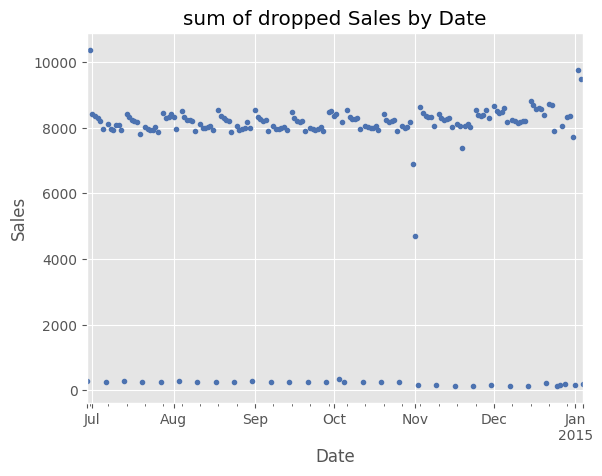

In [ ]:
overall_drop_sales.groupby('Date')['log_sales'].sum().plot(style='.')
plt.title('sum of dropped Sales by Date')
plt.ylabel('Sales')
# I found in internet in this time period Poland had economical deflation and weak external trades caused by several factors.
# We can also see a monthly pattern in sales.

In [ ]:
nodrop_sales = df[~df.Date.isin(overall_drop_sales.Date)]

print(((overall_drop_sales.Promo == 1).sum() + (overall_drop_sales.Promo2).sum()) / len(overall_drop_sales), '% low sales dates promotion days')
print(((nodrop_sales.Promo == 1).sum() + (nodrop_sales.Promo2).sum()) / len(nodrop_sales), '% high sales dates promotion days')
# a 5% less promotion intensity might cause that drop in sales in that time period

0.17100190791645453 % low sales date closed stores
0.1696584147611193 % high sales date closed stores
0.8397685881977743 % low sales dates promotion days
0.891099653775375 % high sales dates promotion days


In [ ]:
print(overall_drop_sales.shape)
print(nodrop_sales.shape)

(178729, 21)
(838473, 21)


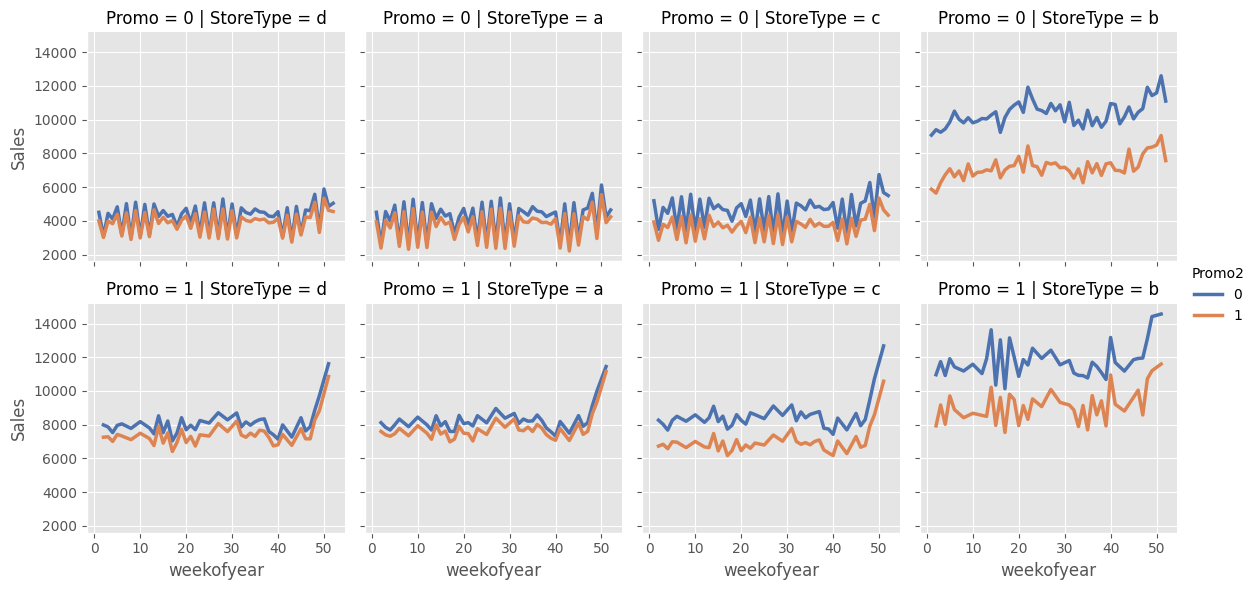

In [ ]:
df['weekofyear'] = df['Date'].dt.isocalendar().week

g = sns.FacetGrid(df, col='StoreType', row='Promo', hue='Promo2')
g.map(sns.lineplot, 'weekofyear', 'Sales', errorbar=None, linewidth=2.5)
g.add_legend()
plt.show()

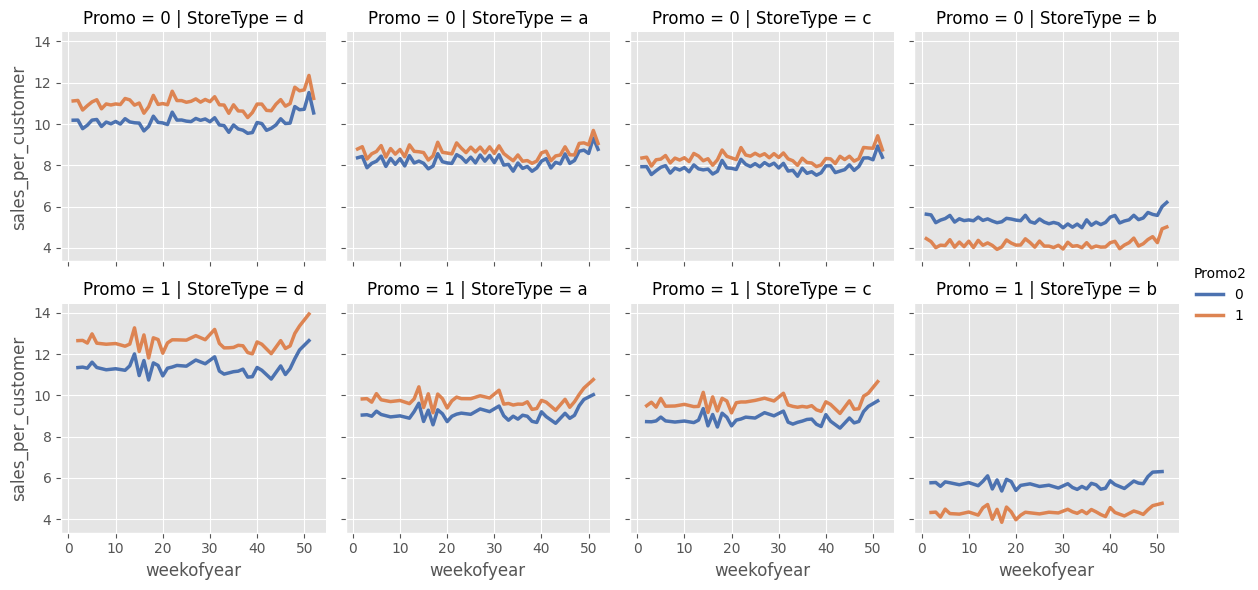

In [ ]:
g = sns.FacetGrid(df, col='StoreType', row='Promo', hue='Promo2')
g.map(sns.lineplot, 'weekofyear', 'sales_per_customer', errorbar=None, linewidth=2.5)
g.add_legend()
plt.show()

# By sales, we can see that overall sales drop significantly when Promo2 is active.
# By sales per customer, Promo2 has a positive impact for StoreTypes A, C, and D.
# Stopping Promo2 for StoreType B could help save costs.

In [ ]:
df[df.CompetitionDistance.isna()][['Store', 'CompetitionDistance']]

,Store,CompetitionDistance
1016385,291,NaN
1016973,879,NaN
1016716,622,NaN
1015270,291,NaN
1015858,879,NaN
...,...,...
1993,879,NaN
1736,622,NaN
290,291,NaN
878,879,NaN


In [ ]:
df['Competition'] = df['CompetitionDistance'].apply(lambda x: 1 if x > 0 else 0)
res = df.groupby('Store').agg(
    sum_store = ('Store', 'count'),
    sum_comp = ('Competition', 'sum')
)

temp = res[res.sum_store != res.sum_comp].reset_index()
temp
# Filtering Stores where CompetitionDistance does not match by date.

df[df.Store.isin(temp)]['CompetitionDistance'].value_counts(dropna=False)


### NEED ATTENTOION!!! ###

Series([], Name: count, dtype: int64)

In [ ]:
high_smask = df.groupby('Date')['Sales'].sum().reset_index()
high_sale_days = high_smask[high_smask.Sales > 12000000]['Date'].to_list()

high_sales_df = df[df.Date.isin(high_sale_days)]
high_sales_df.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,log_sales,sales_z_score,sales_per_customer,weekofyear,Competition
count,10970.000000,10970.000000,10970,10970.000000,10970.000000,10970.000000,10970.000000,10970.000000,10941.000000,7485.000000,7485.000000,10970.000000,5554.000000,5554.000000,10970.000000,10970.000000,10966.000000,10970.0,10970.000000
mean,558.216773,1.711486,2014-04-04 06:54:48.240656384,11887.016955,1100.171923,0.999635,0.898359,0.180857,5417.590714,7.223781,2008.679626,0.506290,23.432841,2011.758192,9.319144,0.618879,11.283461,40.937557,0.997356
min,1.000000,1.000000,2013-12-02 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000,0.000000,-2.194855,3.576734,14.0,0.000000
25%,280.000000,1.000000,2013-12-17 00:00:00,8882.250000,782.000000,1.000000,1.000000,0.000000,710.000000,4.000000,2006.000000,0.000000,13.000000,2011.000000,9.091923,0.550274,9.428281,27.0,1.000000
50%,558.000000,1.000000,2013-12-20 00:00:00,11208.500000,998.000000,1.000000,1.000000,0.000000,2330.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000,9.324517,0.620502,11.059073,51.0,1.000000
75%,837.000000,2.000000,2014-06-30 00:00:00,14047.750000,1287.000000,1.000000,1.000000,0.000000,6890.000000,10.000000,2013.000000,1.000000,37.000000,2013.000000,9.550289,0.688669,12.940482,51.0,1.000000
max,1115.000000,5.000000,2015-03-30 00:00:00,38025.000000,4911.000000,1.000000,1.000000,1.000000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000,10.546025,0.989312,21.461652,52.0,1.000000
std,321.905518,1.276085,NaN,4327.109443,491.796346,0.019093,0.302189,0.384917,7688.155817,3.211254,6.092746,0.499983,14.115060,1.668354,0.391463,0.118195,2.498514,15.366024,0.051350


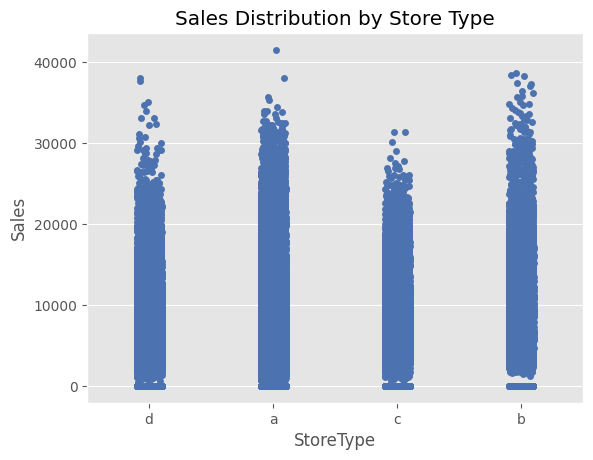

In [ ]:
sns.stripplot(x='StoreType', y='Sales', data=df, jitter=True)
plt.title('Sales Distribution by Store Type')
plt.show()

In [ ]:
df.loc[df['Sales'] > 40000, 'Sales'] = 0

# Removing the sales outlier lowered the score; replacing it with 0 improved it.

In [ ]:
df.query("StoreType=='d' and Sales>37000")

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,log_sales,sales_z_score,sales_per_customer,weekofyear,Competition
627220,261,1,2013-12-16,37646,1964,1,1,0,0,d,...,2015.0,1,39.0,2009.0,"Jan,Apr,Jul,Oct",10.536009,0.986288,19.168024,51,1
424086,57,1,2014-06-16,38037,1970,1,1,0,0,d,...,2014.0,0,NaN,NaN,NaN,10.546341,0.989408,19.308122,25,1


In [ ]:
df['day'] = df['Date'].dt.day
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['weekofyear'] = df['Date'].dt.isocalendar().week.astype(int)

df['CompetitionOpen'] = 12 * (df.year - df.CompetitionOpenSinceYear) + (df.month - df.CompetitionOpenSinceMonth)
df['PromoOpen'] = 12 * (df.year - df.Promo2SinceYear) + (df.weekofyear - df.Promo2SinceWeek) / 4
# Added date features to count how long Competition and Promo have been open

In [ ]:
df.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323345
CompetitionOpenSinceYear     323345
Promo2                            0
Promo2SinceWeek              508025
Promo2SinceYear              508025
PromoInterval                508025
log_sales                         0
sales_z_score                     0
sales_per_customer           172869
weekofyear                        0
Competition                       0
day                               0
month                             0
year                              0
CompetitionOpen              323345
PromoOpen                   

In [ ]:
corr = df.drop(['Date', 'sales_z_score', 'log_sales', 'sales_per_customer', 'StateHoliday', 'StoreType', 'PromoInterval', 'Assortment'], axis=1)
corr = corr.fillna(0).corr()

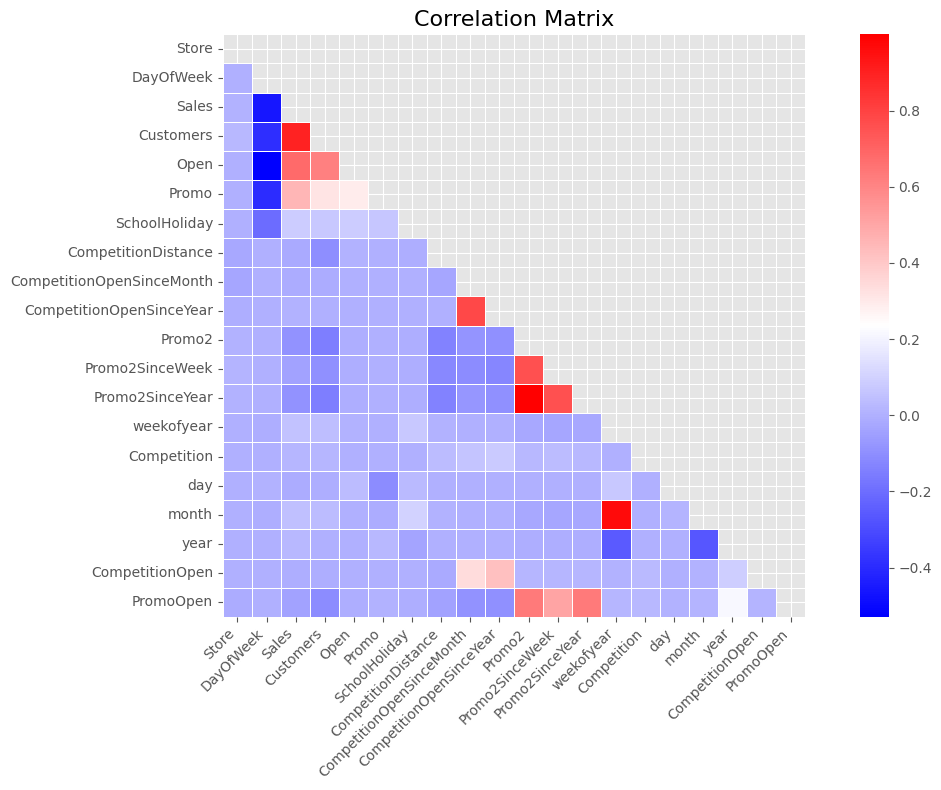

In [ ]:
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    mask=mask,
    cmap="bwr",
    linewidths=0.5,
    square=True
)

plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
############### ADDING TIME RELATED AND LAG FEATURES ###############
df['dow_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

df['is_weekend'] = df['DayOfWeek'].isin([6, 7]).astype(int)
df['is_month_start'] = df['Date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['Date'].dt.is_month_end.astype(int)
df['quarter'] = df['Date'].dt.quarter
df['is_quarter_start'] = df['Date'].dt.is_quarter_start.astype(int)
df['is_quarter_end'] = df['Date'].dt.is_quarter_end.astype(int)

df['lag1'] = df['Sales'].shift(1)
df['lag7'] = df['Sales'].shift(7)

df['rolling_3'] = df['Sales'].shift(1).rolling(window=3).mean()
df['rolling_7'] = df['Sales'].shift(1).rolling(window=7).mean()

df['diff1'] = df['Sales'].diff(1)
df['diff7'] = df['Sales'].diff(7)

In [ ]:
######### PREPROCESSING #########
num_cols = ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']
ohe_cols = ['PromoInterval', 'StateHoliday']
oe_cols = ['StoreType', 'Assortment']
ffill_cols = ['lag1', 'lag7', 'rolling_3', 'rolling_7', 'diff1', 'diff7']

impute_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

ohe_pipeline = Pipeline([
    ('ohe_impute', SimpleImputer(strategy='constant', fill_value='None')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

oe_pipeline = Pipeline([
    ('oe_encode', OrdinalEncoder())
])

ffill_pipeline = Pipeline([
    ('ffill_impute', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer([
    ('impute_only', impute_pipeline, num_cols),
    ('ohe_encode', ohe_pipeline, ohe_cols),
    ('oe_encode', oe_pipeline, oe_cols),
    ('ffil_encode', ffill_pipeline, ffill_cols)
], remainder='passthrough')

In [ ]:
print(df[df.StateHoliday == 'c']['Date'].min())
print(df[df.StateHoliday == 'c']['Date'].max())
print(df['Date'].max())

2013-12-25 00:00:00
2014-12-26 00:00:00
2015-07-31 00:00:00


In [ ]:
X = df.drop(['Date', 'log_sales', 'sales_per_customer'], axis=1)
y = X.pop('Sales')

100%|===================| 210495/210734 [13:00<00:00]        

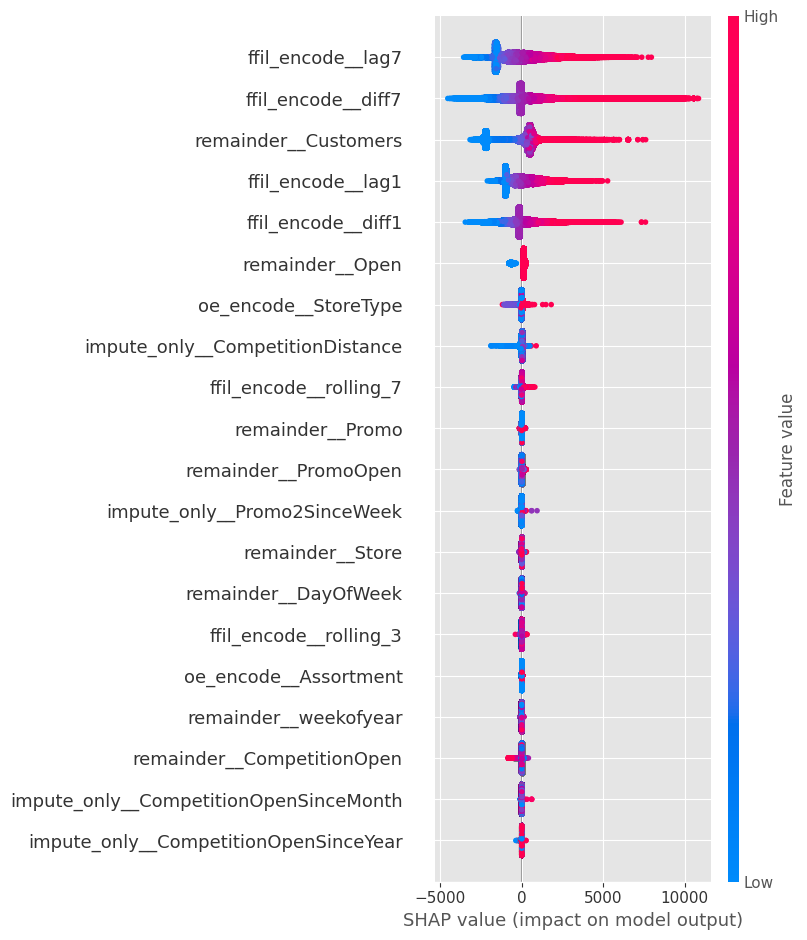

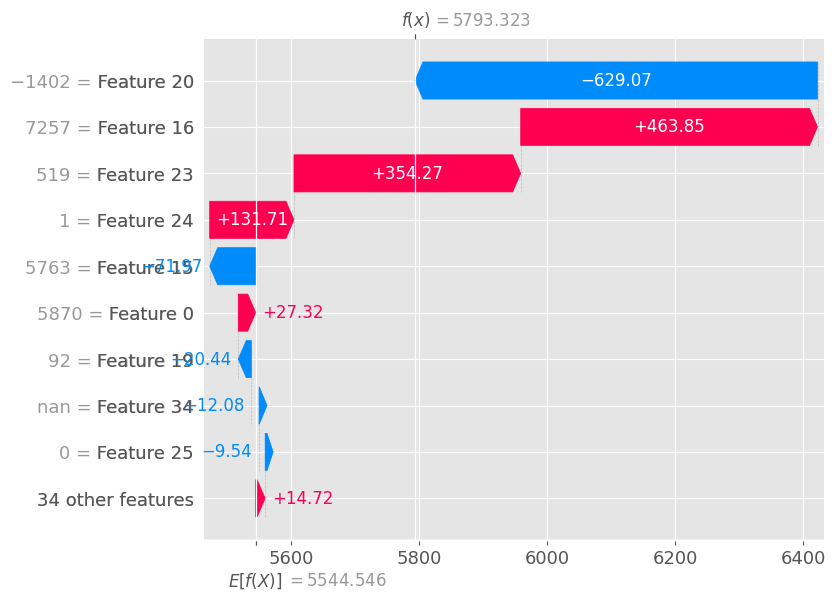

In [ ]:
###### SHAP ######
X_transformed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

unique_dates = df.Date.sort_values().unique()
split_point = int(len(unique_dates)*0.8)

train_dates = unique_dates[:split_point]
test_dates = unique_dates[split_point:]

train_mask = df.Date.isin(train_dates)
test_mask = df.Date.isin(test_dates)

Xs_train, Xs_test = X_transformed[train_mask], X_transformed[test_mask]
ys_train, ys_test = y[train_mask], y[test_mask]

shap_model = xgb.XGBRegressor()
shap_model.fit(Xs_train, ys_train)

explainer = shap.TreeExplainer(shap_model, Xs_train)
shap_values = explainer(Xs_test)

shap.summary_plot(shap_values, Xs_test, feature_names=feature_names)

shap.plots.waterfall(shap_values[0])

In [ ]:
############ HYPERPARAMETER TUNING ############
model = xgb.XGBRegressor(random_state=SEED)

rscv_model = Pipeline([
    ('prep', preprocessor),
    ('model', model)
])

param_dist = {
    'model__n_estimators': [300, 500, 700],
    'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'model__max_depth': [5, 8, 12],
    'model__min_child_weight': [1, 5, 10],
    'model__subsample': [0.7, 0.8, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.5],
    'model__reg_alpha': [0, 0.1, 1],
    'model__reg_lambda': [1, 5, 10]
}

tscv = TimeSeriesSplit(5)

random_search = RandomizedSearchCV(
    estimator=rscv_model,
    param_distributions=param_dist,
    n_iter=30,
    cv=tscv,
    random_state=SEED
)

random_search.fit(X, y)

best_params = random_search.best_params_
best_score = random_search.best_score_
best_estimator = random_search.best_estimator_

In [ ]:
best_params

{'model__subsample': 0.7,
 'model__reg_lambda': 5,
 'model__reg_alpha': 0.1,
 'model__n_estimators': 700,
 'model__min_child_weight': 10,
 'model__max_depth': 12,
 'model__learning_rate': 0.03,
 'model__gamma': 0.5,
 'model__colsample_bytree': 0.8}

In [ ]:
preds = []
for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    best_estimator.fit(X_train, y_train)
    y_pred = best_estimator.predict(X_val)

    preds.append(np.sqrt(mean_squared_error(y_val, y_pred)))

print('cv score: ', np.mean(preds))

cv score:  163.5756172714117


No kernel connected

Connected to .venv (Python 3.13.7)

Connected to .venv (Python 3.13.7)

Connected to .venv (Python 3.13.7)